In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose,STL


In [2]:
df = pd.read_csv('Base_EMBRAESP_trabalhada.csv')

In [3]:
df.columns

Index(['Unnamed: 0.1', 'ID', 'TIPO_EMP', 'MES_LAN', 'ANO_LAN', 'DATA_ENT',
       'DIST', 'SUBPREF', 'MUNICIPIO', 'TIPO_VIA', 'ZONA', 'DORM_UNID',
       'BANH_UNID', 'GAR_UNID', 'ELEV', 'COB', 'BLOCOS', 'UNIDAND', 'ANDARES',
       'AR_UT_UNID', 'AR_TT_UNID', 'AR_TT_TERR', 'TT_UNID', 'DORM_EMP',
       'BANH_EMP', 'GAR_EMP', 'AU_EMP', 'AT_EMP', 'PC_TT_UN', 'PC_M2_AU',
       'PC_M2_AT', 'PC_TT_ATU', 'PC_AU_ATU', 'PC_AT_ATU', 'PC_EMP_ATU',
       'VLR_US__CO', 'PC_TT_UN_U', 'PC_M2_AU_U', 'PC_M2_AT_U', 'SIST_FINAN',
       'AGENTE', 'INCORPORAD', 'CONSTRUTOR', 'INCORPOR_A', 'CONSTRUT_A',
       'COOPERATIV', 'HOTEL', 'FLAT', 'EXFLAT', 'AP2010', 'SC_2010',
       'RENRESP91', 'RENRESP00', 'RENRESP10', 'PCMEDAU91', 'PCMEDAU00',
       'PCMEDAU10', 'BANH_DORM', 'Unnamed: 0', 'Domicílios_Setor',
       'Média_Moradores_por_domicilio_setor', 'Média_Renda_Responsaveis_Setor',
       'Domicilios no setor censitário', 'Domicilios alugados',
       'Domicilios unipessoais', 'Domicilios 2 ou 3 mo

In [4]:
df['MES_LAN'].head()

0    15-JUL-2004
1    15-DEC-2013
2    15-SEP-2013
3    15-DEC-2012
4    15-DEC-2012
Name: MES_LAN, dtype: object

In [5]:
df['DATA_LANC'] = pd.to_datetime(df['MES_LAN'])

In [6]:
df_mes = df.resample('M', on='DATA_LANC').mean()

C:\Users\Pichau\AppData\Local\Temp\ipykernel_15884\1048010194.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_mes = df.resample('M', on='DATA_LANC').mean()


<AxesSubplot: xlabel='DATA_LANC', ylabel='PC_AU_ATU'>

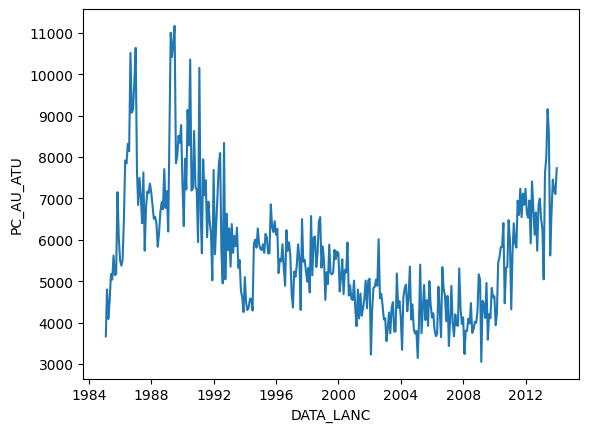

In [7]:
sns.lineplot(data=df_mes, x='DATA_LANC', y='PC_AU_ATU')

In [8]:
significancia = 0.05

teste_fuller_estac = adfuller(df_mes.index) #SEGUNDO NÚMERO DA TUPLA É O P-VALOR DA SIGNIFICÂNCIA

print ("O P-valor do teste é {}".format(teste_fuller_estac[1]))

O P-valor do teste é 0.9443960224340641


In [14]:
df_mes['media_movel'] = df_mes['PC_AU_ATU'].transform(func = lambda x : x.rolling(window=12).agg('mean')) #Realiza a média móvel a partir do número de períodos definidos na window
df_mes['desvio_movel'] = df_mes['PC_AU_ATU'].transform(func = lambda x : x.rolling(window=12).agg('std')) #Realiza a média móvel a partir do número de períodos definidos na window

lista = []

for x,mu,sigma in list(zip(df_mes['PC_AU_ATU'],df_mes['media_movel'],df_mes['desvio_movel'])):
    if (x > mu + 2 * sigma) | (x < mu - 2 * sigma):
        lista.append('outliers')
    else:
        lista.append('inliers')
        
df_mes['outliers'] = lista

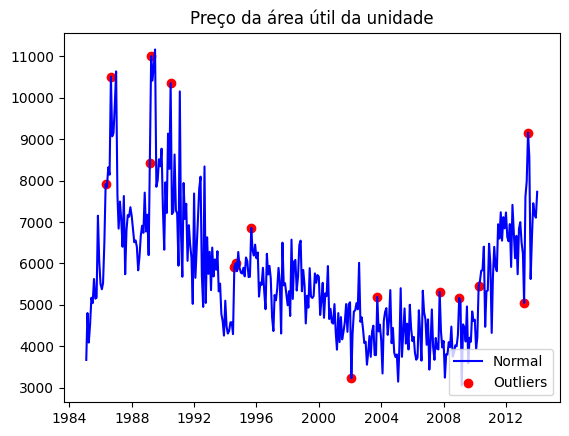

In [16]:
fig, ax = plt.subplots()
ax.plot(df_mes.index,df_mes['PC_AU_ATU'],color='blue', label='Normal')

z = df_mes[df_mes['outliers']=='outliers']
ax.scatter(z.index, z['PC_AU_ATU'],  color='red', label='Outliers')

ax.set_title("Preço da área útil da unidade")
ax.legend(loc='lower right')

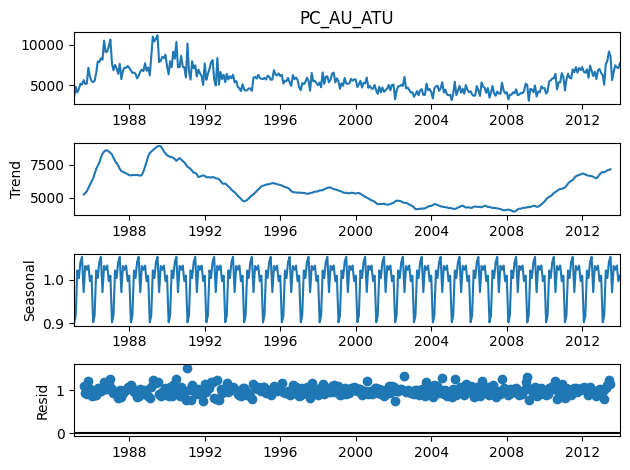

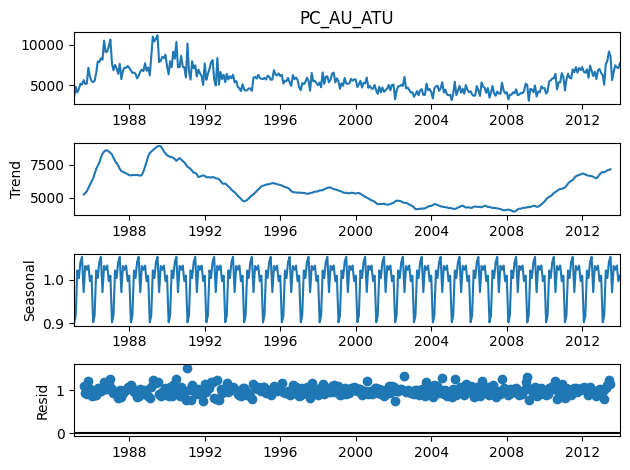

In [20]:
result = seasonal_decompose(df_mes['PC_AU_ATU'], model='multiplicative', period=12)
result.plot()